In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import seaborn as sns
from ast import literal_eval
import re

In [2]:
import matplotlib
cmap = matplotlib.cm.get_cmap('magma_r')

In [3]:
import sys  
sys.path.insert(0, '../../scripts')

from D_plot_specificity_matrix_utils import calc_binding_concordance

In [4]:
#sns.set_context('paper') #, font_scale=2
sns.set_style('ticks', {'axes.edgecolor': '0',  
                        'xtick.color': '0',
                        'ytick.color': '0'})

In [5]:
# Style
# https://seaborn.pydata.org/generated/seaborn.axes_style.html
sns.set_style('ticks', {'axes.edgecolor': '0', #'axes.facecolor':'lightgrey',
                        'xtick.color': '0',
                        'ytick.color': '0'})
sns.set_context("paper",font_scale=2)

In [6]:
def HLA_cd8_converter(x):
    #define format of datetime
    return x.replace("[","").replace("]","").replace(",", "").replace("'","").split(" ")

def cdr3_lst_converter(x):
    #define format of datetime
    return x.replace("[","").replace("]","").replace("'","").split(" ")

def epitope_converter(x):
    #define format of datetime
    return [y for y in x.replace("[","").replace("]","").replace("\n","").split("'") if (y != '') & (y != ' ')]

def peptide_hla_converter(x):
    return re.findall("\w+\s{1}\w{1}\d+", x.replace("[","").replace("]","").replace("\n","").replace("'",""))

def literal_converter(val):
    # replace NaN with '' and perform literal eval on the rest
    return [] if val == '' else literal_eval(val)

converters = {'peptide_HLA_lst': peptide_hla_converter,
              'umi_count_lst_mhc': literal_eval,
              'umi_count_lst_TRA': literal_converter,'umi_count_lst_TRB': literal_converter,
              'cdr3_lst_TRA': cdr3_lst_converter,
              'cdr3_lst_TRB': cdr3_lst_converter,
              'HLA_lst_mhc': cdr3_lst_converter,'HLA_cd8': HLA_cd8_converter} #

In [7]:
def notnan(x):
    return x == x

# Input

In [8]:
CAT_DIR = '../../experiments/exp13/run3/cat/'

In [9]:
VALID = CAT_DIR + "eval_clonotypes/valid_ct.csv"

In [10]:
IDX = '../../experiments/exp13/run3/cat/eval_clonotypes/threshold/indv.csv'

In [11]:
THRSH = '../../experiments/exp13/run3/cat/eval_clonotypes/threshold/opt.csv'

In [12]:
COR = CAT_DIR + 'tables/correlations_v2.xlsx'

# Load

In [13]:
opt_thr = pd.read_csv(THRSH, index_col=0, header=None, names=['thr']).thr.dropna()

In [14]:
idx_df = pd.read_csv(IDX)

In [15]:
df = pd.read_csv(VALID, converters=converters)
df.fillna({'umi_count_mhc':0, 'delta_umi_mhc':0, 'umi_count_mhc_rel':0,
           'umi_count_cd8':0, 'delta_umi_cd8':0,
           'umi_count_TRA':0, 'delta_umi_TRA':0,
           'umi_count_TRB':0, 'delta_umi_TRB':0}, inplace=True) #'cdr3_TRA':'','cdr3_TRB':''

In [16]:
idx = idx_df['optimal threshold'] & idx_df['matching HLA']

In [17]:
#cor_df = pd.read_excel(COR, names=['ct','peptide_HLA','sample_id','n_gems','abs_cells','prop_cells'], sheet_name='Ark1') # v1
cor_df = pd.read_excel(COR, usecols=[3,4,5,6,7,8],
                       names=['peptide','abs_cells','prop_cells','n_gems','sample_id','flow_col'],
                       sheet_name='Ark1') # v2

In [18]:
#cor_df.abs_cells = np.where(cor_df.abs_cells == 0.1, 0, cor_df.abs_cells)
#cor_df.prop_cells = np.where(cor_df.prop_cells == 0.1, 0, cor_df.prop_cells)

# Impute hashing

In [19]:
df[~((df.hash_id == 'Doublet') | (df.hash_id == 'Negative'))].apply(lambda row: int(row.hash_id) == int(row.hto_max_id), axis=1).all()

True

In [20]:
hash_dct = df.set_index('sample_id').HLA_cd8.to_dict()
df['new_hla_cd8'] = df.hto_max_id.map(hash_dct)

In [21]:
singlet_mm = df.loc[(df.hto_max_id != df.sample_id.astype(int)) & (df.hash_id != 'Doublet') & (df.hash_id != 'Negative'),
                    ['sample_id_lst','sample_id','hash_id','hto_classification','hto_max_id','hto_sec_id','HLA_cd8','peptide_HLA',
                     'new_hla_cd8','ct_pep','ct_hla']]
singlet_mm

,sample_id_lst,sample_id,hash_id,hto_classification,hto_max_id,hto_sec_id,HLA_cd8,peptide_HLA,new_hla_cd8,ct_pep,ct_hla
158,"[7, 3, 5, 8, 9, 4, 1, 2, 6, 10]",10.0,6,6,6,2,"[A0201, A0301, B0702]",RVRAYTYSK A0301,"[A0201, B0702]",NaN,NaN
377,"[3, 7, 9, 8, 2, 6, 1, 4, 10]",10.0,4,4,4,10,"[A0201, A0301, B0702]",RPPIFIRRL B0702,"[A0301, B0702]",VLEETSVML A0201,NaN
693,"[5, 3, 4, 9, 8, 7, 6, 1, 2, 10]",10.0,2,2,2,1,"[A0201, A0301, B0702]",RVRAYTYSK A0301,[A0201],NaN,NaN
1057,"[2, 4, 9, 1, 7, 6, 8, 3, 10]",10.0,3,3,3,10,"[A0201, A0301, B0702]",TPRVTGGGAM B0702,[A0201],NaN,NaN
1077,"[4, 9, 7, 2, 1, 6, 3, 10]",10.0,3,3,3,6,"[A0201, A0301, B0702]",TPRVTGGGAM B0702,[A0201],NaN,NaN
1198,"[3, 1, 4, 9, 6, 8, 2, 7, 5, 10]",10.0,5,5,5,7,"[A0201, A0301, B0702]",TPRVTGGGAM B0702,"[A0301, B0702]",NaN,NaN
1352,"[3, 4, 5, 7, 8, 2, 1, 6, 9, 10]",10.0,9,9,9,6,"[A0201, A0301, B0702]",TPRVTGGGAM B0702,"[A0301, B0702]",NaN,NaN
2229,"[4, 9, 7, 8, 6, 2, 1, 10]",10.0,1,1,1,2,"[A0201, A0301, B0702]",RVRAYTYSK A0301,"[A0201, B0702]",NaN,NaN
2727,"[5, 7, 4, 9, 8, 1, 6, 2, 10]",10.0,2,2,2,6,"[A0201, A0301, B0702]",VLEETSVML A0201,[A0201],VLEETSVML A0201,NaN
3175,"[7, 1, 2, 5, 9, 4, 6, 8, 3, 10]",10.0,3,3,3,4,"[A0201, A0301, B0702]",RVRAYTYSK A0301,[A0201],NaN,NaN


In [22]:
doublet_mm = df.loc[(df.hto_max_id != df.sample_id.astype(int)) & (df.hash_id == 'Doublet') & (df.hash_id != 'Negative'),
                    ['sample_id_lst','sample_id','hash_id','hto_classification','hto_max_id','hto_sec_id','HLA_cd8','peptide_HLA', 'new_hla_cd8',
                    'ct_pep','ct_hla']]
doublet_mm

,sample_id_lst,sample_id,hash_id,hto_classification,hto_max_id,hto_sec_id,HLA_cd8,peptide_HLA,new_hla_cd8,ct_pep,ct_hla
33,"[5, 3, 7, 2, 4, 9, 8, 1, 6, 10]",10.0,Doublet,10_6,6,10,"[A0201, A0301, B0702]",RVRAYTYSK A0301,"[A0201, B0702]",NaN,NaN
52,"[8, 7, 9, 1, 6, 10, 4, 2]",2.0,Doublet,2_4,4,2,[A0201],RVRAYTYSK A0301,"[A0301, B0702]",NaN,NaN
73,"[3, 9, 7, 4, 6, 8, 2, 1, 5, 10]",10.0,Doublet,10_5,5,10,"[A0201, A0301, B0702]",RVRAYTYSK A0301,"[A0301, B0702]",NaN,NaN
90,"[7, 9, 8, 1, 5, 10, 4, 2]",2.0,Doublet,2_4,4,2,[A0201],RVRAYTYSK A0301,"[A0301, B0702]",NaN,NaN
107,"[4, 3, 6, 8, 7, 1, 9, 2, 5, 10]",10.0,Doublet,10_5,5,10,"[A0201, A0301, B0702]",RVRAYTYSK A0301,"[A0301, B0702]",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
6024,"[5, 9, 1, 4, 7, 6, 8, 2, 3, 10]",10.0,Doublet,10_3,3,10,"[A0201, A0301, B0702]",RVRAYTYSK A0301,[A0201],VLEETSVML A0201,A0201
6050,"[3, 4, 8, 9, 1, 2, 6, 7, 5, 10]",10.0,Doublet,10_5,5,10,"[A0201, A0301, B0702]",RPPIFIRRL B0702,"[A0301, B0702]",RPPIFIRRL B0702,B0702
6057,"[5, 3, 8, 7, 9, 6, 1, 10, 4, 2]",2.0,Doublet,2_4,4,2,[A0201],RVRAYTYSK A0301,"[A0301, B0702]",RVRAYTYSK A0301,A0201
6066,"[3, 4, 7, 1, 8, 2, 6, 5, 9, 10]",10.0,Doublet,5_9,9,5,"[A0201, A0301, B0702]",TPRVTGGGAM B0702,"[A0301, B0702]",NaN,NaN


In [23]:
doublet_mm[doublet_mm.apply(lambda row: row.peptide_HLA.split()[-1] in row.new_hla_cd8, axis=1)]

,sample_id_lst,sample_id,hash_id,hto_classification,hto_max_id,hto_sec_id,HLA_cd8,peptide_HLA,new_hla_cd8,ct_pep,ct_hla
52,"[8, 7, 9, 1, 6, 10, 4, 2]",2.0,Doublet,2_4,4,2,[A0201],RVRAYTYSK A0301,"[A0301, B0702]",NaN,NaN
73,"[3, 9, 7, 4, 6, 8, 2, 1, 5, 10]",10.0,Doublet,10_5,5,10,"[A0201, A0301, B0702]",RVRAYTYSK A0301,"[A0301, B0702]",NaN,NaN
90,"[7, 9, 8, 1, 5, 10, 4, 2]",2.0,Doublet,2_4,4,2,[A0201],RVRAYTYSK A0301,"[A0301, B0702]",NaN,NaN
107,"[4, 3, 6, 8, 7, 1, 9, 2, 5, 10]",10.0,Doublet,10_5,5,10,"[A0201, A0301, B0702]",RVRAYTYSK A0301,"[A0301, B0702]",NaN,NaN
110,"[3, 9, 2, 7, 8, 1, 6, 4, 10]",10.0,Doublet,10_4,4,10,"[A0201, A0301, B0702]",RVRAYTYSK A0301,"[A0301, B0702]",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5982,"[5, 2, 6, 7, 4, 1, 9, 3, 8, 10]",10.0,Doublet,3_8,8,3,"[A0201, A0301, B0702]",RVRAYTYSK A0301,"[A0301, B0702]",RVRAYTYSK A0301,B0702
6018,"[3, 4, 6, 7, 8, 9, 2, 1, 5, 10]",10.0,Doublet,10_5,5,10,"[A0201, A0301, B0702]",RPPIFIRRL B0702,"[A0301, B0702]",NaN,NaN
6050,"[3, 4, 8, 9, 1, 2, 6, 7, 5, 10]",10.0,Doublet,10_5,5,10,"[A0201, A0301, B0702]",RPPIFIRRL B0702,"[A0301, B0702]",RPPIFIRRL B0702,B0702
6057,"[5, 3, 8, 7, 9, 6, 1, 10, 4, 2]",2.0,Doublet,2_4,4,2,[A0201],RVRAYTYSK A0301,"[A0301, B0702]",RVRAYTYSK A0301,A0201


In [24]:
doublet_mm[doublet_mm.sample_id != 10].apply(lambda row: row.peptide_HLA.split()[-1] in row.new_hla_cd8, axis=1).sum()

41

In [25]:
doublet_mm[doublet_mm.sample_id != 10].apply(lambda row: row.peptide_HLA.split()[-1] in row.HLA_cd8, axis=1).sum()

30

In [26]:
hla_mismatch = doublet_mm[doublet_mm.sample_id != 10].apply(lambda row: any([hla in row.new_hla_cd8 for hla in row.HLA_cd8]), axis=1)

In [27]:
doublet_mm[doublet_mm.sample_id != 10][~hla_mismatch]

,sample_id_lst,sample_id,hash_id,hto_classification,hto_max_id,hto_sec_id,HLA_cd8,peptide_HLA,new_hla_cd8,ct_pep,ct_hla
52,"[8, 7, 9, 1, 6, 10, 4, 2]",2.0,Doublet,2_4,4,2,[A0201],RVRAYTYSK A0301,"[A0301, B0702]",NaN,NaN
90,"[7, 9, 8, 1, 5, 10, 4, 2]",2.0,Doublet,2_4,4,2,[A0201],RVRAYTYSK A0301,"[A0301, B0702]",NaN,NaN
897,"[5, 3, 6, 1, 8, 10, 7, 2]",2.0,Doublet,2_7,7,2,[A0201],TPRVTGGGAM B0702,[B0702],NaN,NaN
1167,"[5, 7, 8, 6, 1, 10, 3, 9, 2]",2.0,Doublet,2_9,9,2,[A0201],FLYALALLL A0201,"[A0301, B0702]",NaN,NaN
2549,"[5, 8, 2, 6, 1, 9, 10, 3, 7]",7.0,Doublet,3_7,3,7,[B0702],VLEETSVML A0201,[A0201],VLEETSVML A0201,A0201
3188,"[5, 3, 4, 1, 6, 7, 8, 10, 9, 2]",2.0,Doublet,2_9,9,2,[A0201],RVRAYTYSK A0301,"[A0301, B0702]",NaN,NaN
4238,"[9, 7, 8, 6, 10, 4, 1, 3, 5, 2]",2.0,Doublet,2_5,5,2,[A0201],VLEETSVML A0201,"[A0301, B0702]",NaN,NaN
6057,"[5, 3, 8, 7, 9, 6, 1, 10, 4, 2]",2.0,Doublet,2_4,4,2,[A0201],RVRAYTYSK A0301,"[A0301, B0702]",RVRAYTYSK A0301,A0201


In [28]:
singlet_mm[singlet_mm.sample_id != 10]

,sample_id_lst,sample_id,hash_id,hto_classification,hto_max_id,hto_sec_id,HLA_cd8,peptide_HLA,new_hla_cd8,ct_pep,ct_hla
4409,"[3, 2, 7, 8, 9, 10, 6, 4, 1]",1.0,4,4,4,1,"[A0201, B0702]",RPHERNGFTV B0702,"[A0301, B0702]",TPRVTGGGAM B0702,B0702
5261,"[2, 4, 6, 7, 8, 10, 9, 1]",1.0,9,9,9,1,"[A0201, B0702]",TPRVTGGGAM B0702,"[A0301, B0702]",RVRAYTYSK A0301,NaN


In [29]:
doublet_mm[doublet_mm.sample_id != 10].dropna(subset=['ct_hla']).apply(lambda row: row.ct_hla in row.HLA_cd8, axis=1).sum()

10

In [30]:
df.sample_id = df.sample_id.astype(int).astype(str)
df['sample_id_old'] = df.sample_id
df['HLA_cd8_old'] = df.HLA_cd8
#df.sample_id = np.where((df.hash_id == 'Doublet') | (df.hash_id == 'Negative'), df.hto_max_id, df.hash_id).astype(str) # df.sample_id
df.sample_id = np.where((df.hash_id == 'Doublet') | (df.hash_id == 'Negative'), df.sample_id, df.hash_id).astype(int)
df.HLA_cd8 = df.sample_id.map(hash_dct)

In [31]:
df.loc[df.sample_id_old != df.sample_id.astype(str), ['sample_id_lst','sample_id_old','sample_id','hash_id','hto_classification',
                                          'hto_max_id','hto_sec_id','HLA_cd8_old','HLA_cd8']]

,sample_id_lst,sample_id_old,sample_id,hash_id,hto_classification,hto_max_id,hto_sec_id,HLA_cd8_old,HLA_cd8
158,"[7, 3, 5, 8, 9, 4, 1, 2, 6, 10]",10,6,6,6,6,2,"[A0201, A0301, B0702]","[A0201, B0702]"
377,"[3, 7, 9, 8, 2, 6, 1, 4, 10]",10,4,4,4,4,10,"[A0201, A0301, B0702]","[A0301, B0702]"
693,"[5, 3, 4, 9, 8, 7, 6, 1, 2, 10]",10,2,2,2,2,1,"[A0201, A0301, B0702]",[A0201]
1057,"[2, 4, 9, 1, 7, 6, 8, 3, 10]",10,3,3,3,3,10,"[A0201, A0301, B0702]",[A0201]
1077,"[4, 9, 7, 2, 1, 6, 3, 10]",10,3,3,3,3,6,"[A0201, A0301, B0702]",[A0201]
1198,"[3, 1, 4, 9, 6, 8, 2, 7, 5, 10]",10,5,5,5,5,7,"[A0201, A0301, B0702]","[A0301, B0702]"
1352,"[3, 4, 5, 7, 8, 2, 1, 6, 9, 10]",10,9,9,9,9,6,"[A0201, A0301, B0702]","[A0301, B0702]"
2229,"[4, 9, 7, 8, 6, 2, 1, 10]",10,1,1,1,1,2,"[A0201, A0301, B0702]","[A0201, B0702]"
2727,"[5, 7, 4, 9, 8, 1, 6, 2, 10]",10,2,2,2,2,6,"[A0201, A0301, B0702]",[A0201]
3175,"[7, 1, 2, 5, 9, 4, 6, 8, 3, 10]",10,3,3,3,3,4,"[A0201, A0301, B0702]",[A0201]


In [32]:
# v2
# df = pd.merge(df, cor_df, on=['sample_id','peptide'], how='outer')

# Filter

In [33]:
idx1 = eval(' & '.join([f'(df.{k} >= {abs(v)})' for k,v in opt_thr.items()]))
idx3 = df.apply(lambda row: row.peptide_HLA.split()[-1] in row.HLA_cd8 if (notnan(row.peptide_HLA) & notnan(row.HLA_cd8)) else False, axis=1)

idx = idx1 & idx3

In [34]:
bc_dct = {'1':'BC300',
          '2':'BC316',
          '3':'BC126',
          '4':'BC328',
          '5':'BC62',
          '6':'BC355',
          '7':'BC360',
          '8':'BC314',
          '9':'BC353',
          '10':'BCmix'}

In [35]:
df['bc'] = df.sample_id.astype(str).map(bc_dct)

In [36]:
frq_cd8 = {'BC314':'2.78%','BC316': '0.04%', 'BC328': '1.14%', 'BC353': '2.13%', 'BC355': '0.61%', 'BC360': '2.05%',
           'BC62': '3.65%', 'BC300': '0.98%', 'BC126': '0.38%', 'BC88': '0.02%', 'BC83': '0.42%', 'BC11': '0.53%',
           'BC76': '0.03%', 'BC342': '0.01%', 'BC311': '1.02%', 'BC341': '29.26%'}

In [37]:
df['frq_cd8'] = df.bc.map(frq_cd8)

# Plot peptide per sample
Removing sample 10

In [38]:
plt_df = df[idx & (df.sample_id != 10)].groupby(['peptide_HLA','sample_id']).ct.size().to_frame().reset_index()

In [39]:
dct = plt_df.groupby('peptide_HLA').ct.sum()
plt_df['cts_per_peptide'] = plt_df.peptide_HLA.map(dct)
plt_df['pep_norm'] = plt_df.ct / plt_df.cts_per_peptide * 100

In [40]:
dct = plt_df.groupby('sample_id').ct.sum()
plt_df['cts_per_sample'] = plt_df.sample_id.map(dct)

In [41]:
plt_df['cts_norm'] = plt_df.ct / plt_df.cts_per_sample * 100

In [42]:
plt_df.sort_values(by='sample_id', inplace=True)
plt_df.sample_id = plt_df.sample_id.astype(int).astype(str)

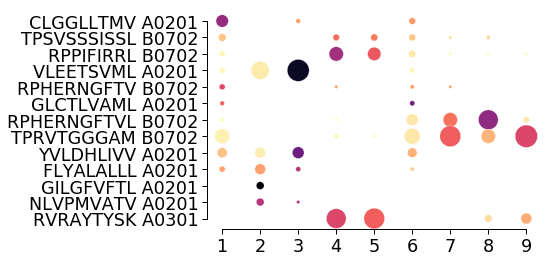

In [43]:
sns.scatterplot(data=plt_df, x='sample_id',y='peptide_HLA',
                size='cts_norm',sizes=(10,500),
                hue='pep_norm',palette='magma_r', legend=False)
plt.ylabel('')
plt.xlabel('')
sns.despine(trim=True)
#plt.savefig('../../experiments/exp13/run3/plt/specificity_matrix/peptide_per_clonotype_by_gem_size/indv/thr_hla_pep_by_sample.impute.png', bbox_inches='tight', dpi=300)
plt.show()

In [44]:
# v1
#dct = cor_df.groupby(['sample_id','peptide_HLA']).abs_cells.max()
#df['abs_cells'] = df.set_index(['sample_id','peptide_HLA']).index.map(dct)
#dct = cor_df.groupby(['sample_id','peptide_HLA']).prop_cells.max()
#df['prop_cells'] = df.set_index(['sample_id','peptide_HLA']).index.map(dct)

In [45]:
def get_cols(s):
    cmap = sns.color_palette("husl", s.nunique())
    return {p:matplotlib.colors.rgb2hex(c) for p,c in zip(s.unique(), cmap)}

In [46]:
df['colors'] = df.peptide_HLA.map(get_cols(df.peptide_HLA))

# Scatter: detected cells versus captured cells

In [360]:
def pie_scatter(df, g, i, j, ax, r=0.5): 
    # radius for pieplot size on a scatterplot
    w = g.groupby('ct').gem.size().sort_values(ascending=False).values
    col = g.colors.drop_duplicates().values[0]
    
    r1 = 0.5 * r #(f**0.3) * 1.1
    r2 = 0.3 * r #(f**0.3) * 1.1
    
    c = np.append(['darkslategrey']*sum(w > 1), 'lightgrey') # dimgrey
    w = np.append(w[w > 1], sum(w == 1)) # collapse all cts of 1 GEM into the last wedge
    
    if len(w) > 1:
        c[0] = col
    
    #ax.pie(w, center=(i,j), radius=r1, colors=c, startangle=90, wedgeprops={'edgecolor':'white', 'width':r2}, frame=True) # 'linewidth':1, 
    ax.scatter(x=i, y=j, s=r1, c=col, edgecolor=col, marker='o') #'o' *200

AttributeError: 'DataFrame' object has no attribute 'abs_cells'

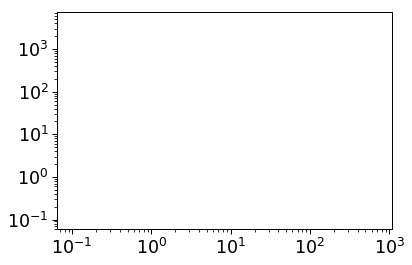

In [361]:
fig, ax = plt.subplots() #figsize=(9,9)
#sns.scatterplot(data=plt_df, x='sample_id',y='peptide_HLA',size=0, legend=False, ax=ax)
ax.scatter(x=cor_df.n_gems, y=cor_df.abs_cells, s=0, marker='X') #epitope_rank
ax.set_xscale('log')
ax.set_yscale('log')

grp = df[idx].groupby(['sample_id','epitope_rank'])
for (s, p), g in grp:
    x = len(g)
    y = g.abs_cells.unique()[0]
    #print(s,p,x,y)
    pie_scatter(df[idx], g, x, y, ax, r=50)

ax.set_xlim(0.1, 1000)
ax.set_ylim(0.08, 10000)
sns.despine(trim=True) #, offset=10
plt.show()

In [43]:
plt_df = df[idx].copy()
dct = plt_df.groupby(['sample_id','peptide_HLA']).gem.size()
plt_df['n_gems'] = plt_df.set_index(['sample_id','peptide_HLA']).index.map(dct)

In [101]:
#bc_dct = {'1':'BC300',
#          '2':'BC316',
#          '3':'BC126',
#          '4':'BC328',
#          '5':'BC62',
#          '6':'BC355',
#          '7':'BC360',
#          '8':'BC314',
#          '9':'BC353',
#          '10':'BC311, BC11, BC83, BC88, BC341, BC342, BC76'}

In [213]:
df.cdr1_TRA.dropna() #.columns.to_list()

0        YGATPY
1         TSINN
2        TSGFYG
3        DSAIYN
4         TSINN
         ...   
4118     DSSSTY
4119     VSGNPY
4121     TSGFYG
4122    TSDQSYG
4124     TSGFNG
Name: cdr1_TRA, Length: 3603, dtype: object

In [397]:
plt_df[(plt_df.peptide=='RPHERNGFTVL') & (plt_df.sample_id ==5)]

,gem,clonotype,num_clonotype,ct,genes_TRA,genes_TRB,genes_lst_TRA,genes_lst_TRB,length_TRA,cdr1_TRA,...,hla_match,ct_match,valid_ct,train_label,test_label,new_hla_cd8,sample_id_old,HLA_cd8_old,colors,n_gems


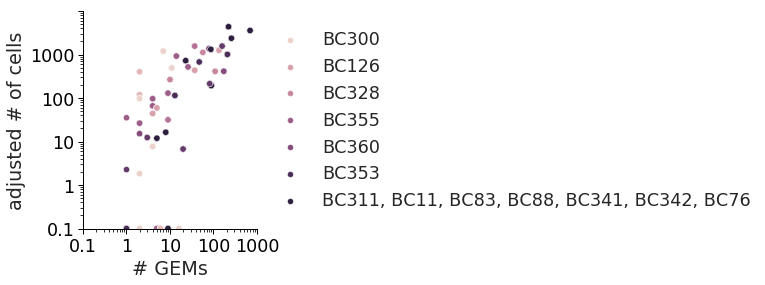

In [66]:
fig = plt.figure()

##calculate equation for trendline
#x = plt_df.dropna(subset=['n_gems','prop_cells'], how='any').n_gems.values
#y = plt_df.dropna(subset=['n_gems','prop_cells'], how='any').prop_cells.values
#z = np.polyfit(x, y, 1)
#p = np.poly1d(z)
#plt.plot(np.sort(x), p(np.sort(x)))

ax = sns.scatterplot(data=plt_df, x='n_gems',y='abs_cells',hue='sample_id', s=40, lw=0.001) #s=120, hue='peptide_HLA',style='sample_id',y='prop_cells'

h,l = ax.get_legend_handles_labels()

ax.set_xlabel('# GEMs')
ax.set_ylabel('adjusted # of cells')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.1, 1000)
ax.set_ylim(0.1, 10000)
sns.despine(trim=True)
#ax.legend(bbox_to_anchor=(1, 0.5), loc=6, ncol=2,frameon=False, labelspacing=0.5, title='UMI')

ax.set_xticklabels(['0.1','1','10','100','1000'])
ax.set_yticklabels(['0.1','1','10','100','1000'])
ax.set_aspect('equal') #, adjustable='box'

ax.legend(h, [bc_dct[i] for i in l], bbox_to_anchor=(1, 0.5), loc=6, frameon=False)

# legends with both peptide and sample_id
#lt = fig.legend(h[1:14],l[1:14],bbox_to_anchor=(1, 1), loc=2, frameon=False, labelspacing=0.5, bbox_transform=fig.transFigure, title='Peptide HLA', fontsize=11.5, markerscale=1.5)
#lt.get_title().set_position((10, 0))
#lt = ax.legend(h[15:], buffy_coat, bbox_to_anchor=(1.45, 1), loc=2, frameon=False, labelspacing=0.5, bbox_transform=fig.transFigure, title='Sample', fontsize=11.5, markerscale=1.5) #
#lt.get_title().set_position((-10, 0))
#for t in lt.texts:
#    t.set_verticalalignment('center')
#plt.savefig('../../experiments/exp13/run3/plt/specificity_matrix/peptide_per_clonotype_by_gem_size/comb/scatter.png', bbox_inches='tight', dpi=300)

plt.show()

# Pie scatter

In [47]:
def pie_scatter(df, g, s, p, ax, var='gem', r=0.5): 
    # widget sizes
    w = g.groupby('ct').gem.size().sort_values(ascending=False).values
    #c = g.groupby('ct').colors.apply(list).apply(lambda x: x[0]).values
    
    if var == 'gem':
        f = w.sum()/len(df[df.sample_id==s])#**0.5 #*10 #**0.5 #df.gem.nunique()
    else:
        f = g[var].unique()
        assert len(f)==1
        f = f[0]/100
    r1 = 0.5 * (f**0.3) * 1.1
    r2 = 0.3 * (f**0.3) * 1.1
    
    # radius for pieplot size on a scatterplot
    #cmap = [matplotlib.colors.rgb2hex(c) for c in sns.color_palette("magma_r", 100)]
    f2 = w.sum()/len(df[df.epitope_rank==p])
    col = matplotlib.colors.rgb2hex(cmap(f2))
    
    #c = np.append(c[w > 1], 'lightgrey') #c[-1] # color hack for the collapsed cts
    c = np.append(['darkslategrey']*sum(w > 1), 'lightgrey') # dimgrey
    w = np.append(w[w > 1], sum(w == 1)) # collapse all cts of 1 GEM into the last wedge
    
    if len(w) > 1:
        c[0] = col
    
    if var == 'gem':
        #print(f, r1)
        ax.pie(w, center=(s,p), radius=r1, colors=c, startangle=90, wedgeprops={'edgecolor':'white', 'width':r2}, frame=True) # 'linewidth':1, 
        mag = 500 if f > 0.5 else 200
        ax.scatter(x=s, y=p, s=r1*mag, c=col, marker='o') #'o' #r1*500
    else:
        c = g.flow_col.unique()
        assert len(c) == 1
        ax.pie([1], center=(s,p), radius=r1, colors=c, startangle=90, wedgeprops={'edgecolor':None}, frame=True) # 'linewidth':1, #['darkslategrey']
        ax.scatter(x=s, y=p, s=r1*500, c=col, marker='o',alpha=0) # hack to order axes...
        #ax.pie(w, center=(s,p), radius=r1, colors=c, startangle=90, wedgeprops={'edgecolor':'white', 'width':r2, 'alpha':0.5}, frame=True) # 'linewidth':1, 
        #ax.scatter(x=s, y=p, s=r1*2200, c=col, marker='o') #'o'
        

In [48]:
buffy_coat = ['BC300', 'BC316', 'BC126', 'BC328', 'BC62', 'BC355', 'BC360', 'BC314', 'BC353',
              'BC311, BC11,\nBC83, BC88,\nBC341, BC342, BC76']

In [49]:
ignore_peptides = ['NLVPMVATV A0201', 'GILGFVFTL A0201', 'GLCTLVAML A0201']

In [50]:
pie_df = pd.merge(df[idx & (df.sample_id != 10) & (~df.peptide_HLA.isin(ignore_peptides))],
                  cor_df[cor_df.sample_id != 10], on=['sample_id','peptide'], how='outer')

In [51]:
# Amalie has set values to 0.1
# df.prop_cells = np.where(df.prop_cells == 0.1, 0, df.prop_cells) # v1
pie_df.prop_cells = np.where(pie_df.abs_cells == 0.1, 0, pie_df.prop_cells) # v2

In [52]:
dct = df.set_index('peptide').epitope_rank.to_dict()
pie_df['epitope_rank'] = pie_df.peptide.map(dct)
dct = df.set_index('peptide').peptide_HLA.to_dict()
pie_df['peptide_HLA'] = pie_df.peptide.map(dct)

In [53]:
pie_df.flow_col.fillna('darkslategrey', inplace=True)

/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/matplotlib/patches.py:1059: RuntimeWarning: invalid value encountered in true_divide
  v2 = arc.vertices[::-1] * (self.r - self.width) / self.r


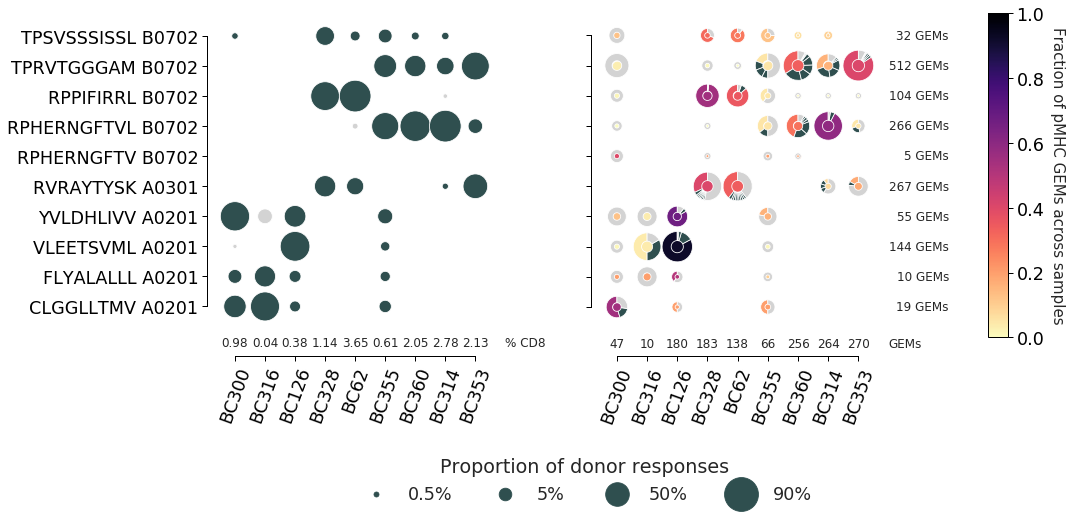

In [54]:
fig, axes = plt.subplots(1,2, figsize=(14,9), sharey=True)
fig.subplots_adjust(wspace=0.3)
#fig = plt.figure(figsize=(14,9))
#gs = gridspec.GridSpec(1, 3, width_ratios=[0.5, 0.5, 0.1], wspace=0.05) #6, left=0.05
#ax1 = fig.add_subplot(gs[0]) #ax1 = plt.subplot(gs[0, 0])
#ax2 = fig.add_subplot(gs[1], sharey=ax1) #ax2 = plt.subplot(gs[0,1])
#ax3 = fig.add_subplot(gs[2], sharey=ax1) #ax3 = plt.subplot(gs[0, 2])

#pie_df = df[idx & (df.sample_id != 10) & (~df.peptide_HLA.isin(ignore_peptides))]

#sns.scatterplot(data=plt_df, x='sample_id',y='peptide_HLA',size=0, legend=False, ax=ax)
for ax,var in zip(axes, ['prop_cells','gem']):
    ax.scatter(x=pie_df.sample_id, y=pie_df.epitope_rank, s=0, marker='o') #epitope_rank
    y_init = ax.get_ylim()
    x_init = ax.get_xlim()

    grp = pie_df.groupby(['sample_id','epitope_rank'])
    for (s, p), g in grp:
        #w = g.groupby('ct').gem.size()
        #c = g.groupby('ct').colors.apply(list).apply(lambda x: x[0])
        #print(s,p, g.ct.nunique(), sum(w > 1), len(w), len(c))
        #print(s,p)
        pie_scatter(pie_df, g, s, p, ax, var=var)
        
    if var == 'gem':
        for s,c in pie_df.dropna(subset=['ct']).groupby('sample_id').gem.size().iteritems():
            ax.annotate("%d" % c, xy=(s,3.5), xytext=(s,3), ha="center", va="top", size=12) #, rotation=90 xytext=(s,14), 
        ax.annotate("GEMs", xy=(9,3.5), xytext=(10,3), ha="left", va="top", size=12)
        for p,c in pie_df.dropna(subset=['ct']).groupby('epitope_rank').gem.size().iteritems():
            ax.annotate("%d GEMs" % c, xy=(9,p), xytext=(12,p), ha="right", va="center", size=12) #, rotation=90 xytext=(s,14),
    else:
        for s,c in pie_df.dropna(subset=['ct']).set_index('sample_id').frq_cd8.drop_duplicates().iteritems():
            ax.annotate("%s" % c[:-1], xy=(s,3.5), xytext=(s,3), ha="center", va="top", size=12)
        ax.annotate("% CD8", xy=(9,3.5), xytext=(10,3), ha="left", va="top", size=12)

    #ax.autoscale(enable=False)
    #ax.yaxis.set_ticks(range(1, round(y_init[1]), 1))
    #ax.xaxis.set_ticks(range(1, round(x_init[1]), 1))
    
    ax.xaxis.set_ticks(range(1, 10, 1))
    ax.yaxis.set_ticks(range(3, 14, 1))
    ax.set_yticklabels(pie_df.sort_values(by='epitope_rank').peptide_HLA.unique())
    #ax.set_xticklabels(buffy_coat[:-1], rotation=70, ha='center')
    
sns.despine(trim=True, offset={'bottom':20})
axes[0].set_xticklabels(buffy_coat[:-1], rotation=70, ha='center')
axes[1].set_xticklabels(buffy_coat[:-1], rotation=70, ha='center')
    
sm = plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0,vmax=1), cmap=cmap) # hack for cbar
sm.set_array([]) # hack for cbar
#fig.colorbar(sm, ax=ax3, use_gridspec=True) #pad=0.01
#fig.colorbar(sm, ax=ax, orientation='horizontal', label='Binding Concordance', fraction=0.06*6/fig_height, pad=0.15*6/fig_height) 
#https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.colorbar.html

fig.subplots_adjust(right=0.8) #0.9
cbar_ax = fig.add_axes([0.9, 0.25, 0.02, 0.5]) #[0.85, 0.15, 0.05, 0.7] #[0.9, 0.2, 0.02, 0.6]
fig.colorbar(sm, cax=cbar_ax)
cbar_ax.get_yaxis().labelpad = 20
cbar_ax.set_ylabel('Fraction of pMHC GEMs across samples', rotation=270, size=15)

for r,l in zip([0.1*250, 0.2*800, 0.4*1400, 0.5*2300], ['0.5%','5%','50%','90%']): #[0.16*500, 0.271*1500, 0.443*2200, 0.53*3000]
    #r = 0.5 * (f**0.3) * 1.1
    #print(r)
    ax.scatter(x=[], y=[], s=r, marker='o', label=l, c='darkslategrey') #*2000
h,l = ax.get_legend_handles_labels()
ax.legend(h[1:], l[1:], title='Proportion of donor responses', bbox_to_anchor=(0.5, 0.09), loc=9, bbox_transform=fig.transFigure, ncol=4, frameon=False, labelspacing=0.5)



#plt.savefig('../../experiments/exp13/run3/plt/specificity_matrix/peptide_per_clonotype_by_gem_size/comb/thr_hla_pep_by_sample.pie.3.png', bbox_inches='tight', dpi=300)

plt.show()

In [55]:
from scipy import stats

In [56]:
groups = pie_df.groupby('sample_id')

In [57]:
for s, grp in groups:
    a = grp.peptide_HLA.value_counts()
    b = grp.groupby('peptide_HLA').prop_cells.max()
    c = pd.merge(a,b,left_index=True, right_index=True).rename(columns={'peptide_HLA':'GEMs'}).fillna(0)
    rho, pval = stats.spearmanr(c.GEMs, c.prop_cells)
    print(s, rho, pval)

1 0.4090909090909091 0.2742584737336379
2 -0.9486832980505139 0.051316701949486114
3 1.0 0.0
4 0.8996469021204838 0.005801284655369255
5 0.8720815992723809 0.05385421772754211
6 0.7384031975509988 0.023083928820591775
7 0.8947368421052632 0.04034313006075297
8 0.8999999999999998 0.03738607346849874
9 1.0 0.0


In [58]:
from math import sqrt
def mcc(tp, fp, tn, fn):

    # https://stackoverflow.com/a/56875660/992687
    x = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    return ((tp * tn) - (fp * fn)) / sqrt(x)

In [59]:
mcc(25, 25, 38, 0)

0.549169647365276

In [60]:
y_true = list()
y_pred = list()
for p in cor_df.peptide.unique():
    print(p)
    for s in [1,2,3,4,5,6,7,8,9]:
        g = pie_df[(pie_df.peptide == p) & (pie_df.sample_id == s)]
        c = cor_df[(cor_df.peptide == p) & (cor_df.sample_id == s)]
        
        ct_count = g.groupby('ct').size()
            
        if all(ct_count == 1) & ~ct_count.empty:
            y_pred.append(0)
        elif any(ct_count > 1) & ~ct_count.empty:
            y_pred.append(1)
        else:
            y_pred.append(-1)
            
        assert len(c) <= 1 
        if all(c.flow_col == 'lightgrey') & ~c.empty:
            y_true.append(0)
        elif all(c.abs_cells > 0.1) & ~c.empty:
            y_true.append(1)
        else:
            y_true.append(-1)
        #y_pred.append(1 if any((pie_df.peptide_HLA == p) & (pie_df.sample_id == s)) else -1)
        #y_true.append(1 if any((cor_df.peptide_HLA == p) & (cor_df.sample_id == s) & (cor_df.prop_cells > 0.1)) else -1)
        

RPHERNGFTVL
TPSVSSSISSL
RVRAYTYSK
RPPIFIRRL
TPRVTGGGAM
CLGGLLTMV
FLYALALLL
YVLDHLIVV
VLEETSVML
RPHERNGFTV


In [61]:
from sklearn.metrics import matthews_corrcoef

In [62]:
matthews_corrcoef(y_true, y_pred)

0.6303024589738093

In [63]:
TP, FP, TN, FN = 0,0,0,0
for i in range(len(y_true)):
    if (y_true[i] >= 0) and (y_pred[i] >= 0):
        TP += 1
    elif (y_true[i] >= 0) and (y_pred[i] < 0):
        FN += 1
    elif (y_true[i] < 0) and (y_pred[i] >= 0):
        FP += 1
    else:
        TN += 1

In [64]:
TP

35

In [65]:
FP

14

In [66]:
TN

39

In [67]:
FN

2

In [68]:
mcc(TP, FP, TN, FN)

0.6736008740978247

In [69]:
recall = TP/(TP+FN)
precis = TP/(TP+FP)

In [70]:
recall

0.9459459459459459

In [71]:
precis

0.7142857142857143

In [72]:
dct = df[idx].dropna(subset=['ct']).groupby(['sample_id','peptide']).gem.size()
cor_df['n_gems'] = cor_df.set_index(['sample_id','peptide']).index.map(dct).fillna(0.1)

In [73]:
plt_df = cor_df[~((cor_df.abs_cells == 0.1) & (cor_df.n_gems == 0.1))].copy()

In [74]:
plt_df

,peptide,abs_cells,prop_cells,n_gems,sample_id,flow_col
0,RPHERNGFTVL,1564.731229,86.929513,158.0,8,darkslategrey
1,TPSVSSSISSL,12.345147,0.685842,3.0,8,darkslategrey
2,RVRAYTYSK,6.721965,0.373442,20.0,8,darkslategrey
3,RPPIFIRRL,2.262200,0.125678,1.0,8,lightgrey
4,TPRVTGGGAM,213.939459,11.885526,82.0,8,darkslategrey
5,CLGGLLTMV,1164.454976,64.691943,0.1,2,darkslategrey
6,FLYALALLL,400.947867,22.274882,2.0,2,darkslategrey
7,YVLDHLIVV,119.431280,6.635071,2.0,2,lightgrey
8,VLEETSVML,0.100000,0.005556,6.0,2,darkslategrey
10,RPHERNGFTVL,0.100000,0.005556,1.0,4,darkslategrey


In [75]:
palette = ['#9e0142','#d53e4f','#f46d43','#ffad01','#ffdf22','#bff128', #'#fdae61''#fee08b''#e6f598'
           '#abdda4','#66c2a5','#3288bd','#5e4fa2']
plt_df['fc'] = plt_df.sample_id.map(dict(zip(range(1,len(palette)+1),palette)))
plt_df['ec'] = plt_df.fc

In [76]:
plt_df.fc = np.where(plt_df.flow_col == 'lightgrey', 'none',plt_df.fc)

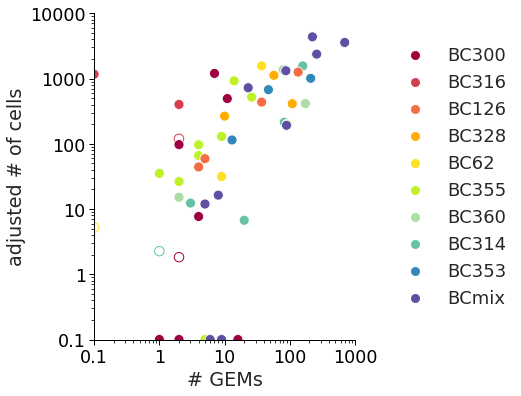

In [77]:
fig, ax = plt.subplots(figsize=(6,6)) #figsize=(9,9)
#sns.scatterplot(data=plt_df, x='sample_id',y='peptide_HLA',size=0, legend=False, ax=ax)
sns.scatterplot(data=plt_df[plt_df.flow_col == 'lightgrey'], x='n_gems',y='abs_cells',
                edgecolor=plt_df[plt_df.flow_col == 'lightgrey'].ec, facecolor="none",
                s=90, linewidth=1, ax=ax) #s=120, hue='peptide_HLA',style='sample_id',y='prop_cells'

sns.scatterplot(data=plt_df[plt_df.flow_col != 'lightgrey'], x='n_gems',y='abs_cells',
                #edgecolor='face', facecolor="none",
                hue='sample_id',
                palette=['#9e0142','#d53e4f','#f46d43','#ffad01','#ffdf22','#bff128', #'#fdae61''#fee08b''#e6f598'
                         '#abdda4','#66c2a5','#3288bd','#5e4fa2'],
                s=100, lw=0.001, ax=ax) #s=120, hue='peptide_HLA',style='sample_id',y='prop_cells'
#ax.scatter(x=cor_df.n_gems, y=cor_df.abs_cells, color='darkslategrey', edgecolor='white',s=50) #epitope_rank

h,l = ax.get_legend_handles_labels()

ax.set_xlabel('# GEMs')
ax.set_ylabel('adjusted # of cells')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.1, 1000)
ax.set_ylim(0.1, 10000)
sns.despine(trim=True)
#ax.legend(bbox_to_anchor=(1, 0.5), loc=6, ncol=2,frameon=False, labelspacing=0.5, title='UMI')

ax.set_xticklabels(['0.1','1','10','100','1000'])
ax.set_yticklabels(['0.1','1','10','100','1000','10000'])
ax.set_aspect('equal') #, adjustable='box'

ax.legend(h, [bc_dct[i] for i in l], bbox_to_anchor=(1.1, 0.5), loc=6, frameon=False, markerscale=1.7, prop={'size': 18})

#plt.savefig('../../experiments/exp13/run3/plt/specificity_matrix/peptide_per_clonotype_by_gem_size/comb/scatter.3.png', bbox_inches='tight', dpi=300)


In [195]:
#calculate equation for trendline
x = np.log10(plt_df[~((plt_df.abs_cells == 0.1) | (plt_df.n_gems == 0.1))].n_gems.values)  # 
y = np.log10(plt_df[~((plt_df.abs_cells == 0.1) | (plt_df.n_gems == 0.1))].abs_cells.values) #
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

In [193]:
# #calculate equation for trendline
# x = plt_df[~((plt_df.abs_cells == 0.1) | (plt_df.n_gems == 0.1))].n_gems.values # 
# y = plt_df[~((plt_df.abs_cells == 0.1) | (plt_df.n_gems == 0.1))].abs_cells.values #
# z = np.polyfit(x, y, 1)
# p = np.poly1d(z)

In [227]:
def f_1(y,z=z):
    a, b = z
    x = (np.log10(y)-b)/a
    return 10**x

In [217]:
z

array([0.86026034, 1.17808028])

In [247]:
#10**
p(np.log10(9))

1.9989772609169498

In [246]:
np.log10(100)

2.0

In [ ]:
10*0.86026034+1.17808028

9.78068368

In [231]:
f_1(10)

0.6208584163178661

In [234]:
(10-0.85)/1.1468
#(10-1.17808028)/0.86026034

7.9787234042553195

In [235]:
f_1(100)

9.024671055059887

In [187]:
#(100-0.85)/1.1468
(100-1.17808028)/0.86026034

114.87443408119918

In [236]:
f_1(1000)

131.18077408865756

In [145]:
(1000-0.85)/1.1468

871.2504359958144

In [78]:
from sklearn.metrics import r2_score

In [216]:
10**p(3)

5739.331202173686

In [204]:
10**x

array([158.,   3.,  20.,   1.,  82.,   2.,   2.,  10., 109.,  57.,  13.,
        47., 209.,   4.,   1.,   9.,   2.,  14.,   4.,  26.,  79.,   2.,
       173.,   9.,  91.,  37.,  11.,   2.,   7.,   2.,   4.,   4.,   5.,
        37., 134.,  87.,  23., 222., 258.,   8.,   5., 694.,  89.])

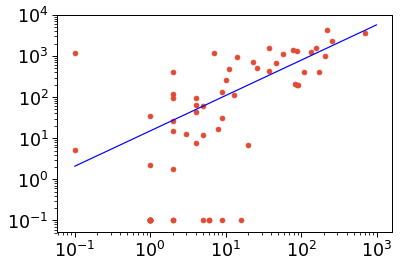

In [241]:
#plt.scatter(10**x,10**y)
plt.scatter(plt_df.n_gems.values, plt_df.abs_cells.values)
#plt.plot(10**x,10**p(x), color='blue')
plt.plot(np.arange(0.1,1000), 10**p(np.log10(np.arange(0.1,1000))), color='blue')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

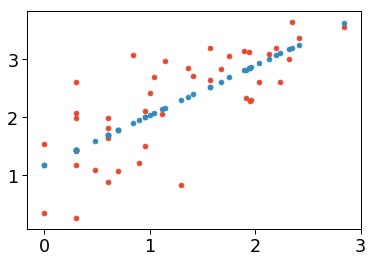

In [196]:
plt.scatter(x,y)
plt.scatter(x,p(x))

In [237]:
r2_score(y, p(x))

0.5635506458014583

In [238]:
r2_score(10**y, 10**p(x))

0.5652882443238103

In [136]:
(500 - 191.66031933) / 6.1711817

49.96444695024942

In [137]:
49.96/500*100

9.991999999999999

In [135]:
130/1000*100

13.0

In [91]:
stats.pearsonr(cor_df.n_gems, cor_df.abs_cells)

(0.7630209260595757, 1.3766438902002523e-12)

In [120]:
plt_df

,peptide,abs_cells,prop_cells,n_gems,sample_id,flow_col,fc,ec
0,RPHERNGFTVL,1564.731229,86.929513,158.0,8,darkslategrey,#66c2a5,#66c2a5
1,TPSVSSSISSL,12.345147,0.685842,3.0,8,darkslategrey,#66c2a5,#66c2a5
2,RVRAYTYSK,6.721965,0.373442,20.0,8,darkslategrey,#66c2a5,#66c2a5
3,RPPIFIRRL,2.262200,0.125678,1.0,8,lightgrey,none,#66c2a5
4,TPRVTGGGAM,213.939459,11.885526,82.0,8,darkslategrey,#66c2a5,#66c2a5
5,CLGGLLTMV,1164.454976,64.691943,0.1,2,darkslategrey,#d53e4f,#d53e4f
6,FLYALALLL,400.947867,22.274882,2.0,2,darkslategrey,#d53e4f,#d53e4f
7,YVLDHLIVV,119.431280,6.635071,2.0,2,lightgrey,none,#d53e4f
8,VLEETSVML,0.100000,0.005556,6.0,2,darkslategrey,#d53e4f,#d53e4f
10,RPHERNGFTVL,0.100000,0.005556,1.0,4,darkslategrey,#ffad01,#ffad01


In [153]:
pie_df.groupby(['sample_id','peptide_HLA']).prop_cells.max()

sample_id  peptide_HLA      
1          CLGGLLTMV A0201      56.403270
           FLYALALLL A0201       9.536785
           RPHERNGFTV B0702      0.000000
           RPHERNGFTVL B0702     0.000000
           RPPIFIRRL B0702       0.000000
           TPRVTGGGAM B0702      0.000000
           TPSVSSSISSL B0702     0.000000
           VLEETSVML A0201       0.000000
           YVLDHLIVV A0201      34.059946
2          FLYALALLL A0201       0.000000
           VLEETSVML A0201       0.000000
           YVLDHLIVV A0201       0.000000
3          CLGGLLTMV A0201       0.000000
           FLYALALLL A0201       0.000000
           VLEETSVML A0201      66.666667
           YVLDHLIVV A0201      33.333333
4          RPHERNGFTV B0702           NaN
           RPHERNGFTVL B0702     0.000000
           RPPIFIRRL B0702      62.365900
           RVRAYTYSK A0301      22.863985
           TPRVTGGGAM B0702      0.000000
           TPSVSSSISSL B0702    14.770115
5          RPPIFIRRL B0702      81.549579
     

In [154]:
pie_df.prop_cells > 0 

0        True
2        True
3        True
4        True
6       False
        ...  
4108     True
4116     True
4117     True
4121    False
4122     True
Name: prop_cells, Length: 1415, dtype: bool

In [122]:
FP = sum(pie_df.prop_cells == 0)
FP

92

In [124]:
TP = sum(pie_df.prop_cells > 0)
TP

1321

In [132]:
cor_df[~(cor_df.peptide_HLA.isin(pie_df.peptide_HLA))] # & cor_df.sample_id.isin(pie_df.sample_id)

,ct,peptide_HLA,sample_id,n_gems,abs_cells,prop_cells
50,848,GILGFVFTL A0201,10,1,0.1,0.1


In [194]:
df.loc[(df.sample_id!= 10) & (df.prop_cells < 51) & (df.prop_cells > 48), ['peptide_HLA','sample_id','prop_cells']]

,peptide_HLA,sample_id,prop_cells
2,RPHERNGFTVL B0702,8,48.693645
41,RPHERNGFTVL B0702,8,48.693645
46,RPHERNGFTVL B0702,8,48.693645
78,RPHERNGFTVL B0702,8,48.693645
138,RPHERNGFTVL B0702,8,48.693645
...,...,...,...
5716,RPHERNGFTVL B0702,8,48.693645
5885,RPHERNGFTVL B0702,8,48.693645
5930,RPHERNGFTVL B0702,8,48.693645
5967,RPHERNGFTVL B0702,8,48.693645


In [154]:
df.loc[idx & (df.peptide_HLA == 'RPHERNGFTVL B0702') & (df.sample_id==8), ['gem','ct','abs_cells','prop_cells']]

,gem,ct,abs_cells,prop_cells
2,AAACCTGCAATCCGAT-1,3.0,876.485618,48.693645
41,AAAGTAGGTAACGACG-1,3.0,876.485618,48.693645
46,AAATGCCGTCCAGTAT-1,3.0,876.485618,48.693645
78,AACGTTGAGTAACCCT-1,3.0,876.485618,48.693645
138,AAGCCGCGTCACCTAA-1,61.0,876.485618,48.693645
...,...,...,...,...
3997,TTCTTAGAGCGTGTCC-1,61.0,876.485618,48.693645
4012,TTGAACGTCACTCCTG-1,3.0,876.485618,48.693645
4033,TTGCCGTTCGCTTGTC-1,3.0,876.485618,48.693645
4071,TTGTAGGGTAATCACC-1,3.0,876.485618,48.693645


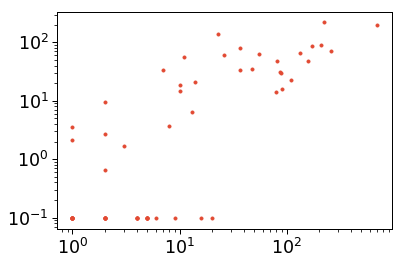

In [36]:
plt.scatter(x=cor_df.n_gems, y=cor_df.prop_cells, s=10, marker='o') #epitope_rank
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

## Test pie scatter

In [102]:
import random

def rand(): #simulate some random data
    return [random.randint(0,100) for _ in range(10)]

def plot_pie(x, ax): 
    ax.pie(x[['a','b','c']], center=(x['lat'],x['lon']), radius=1,colors=['r', 'b', 'g'])


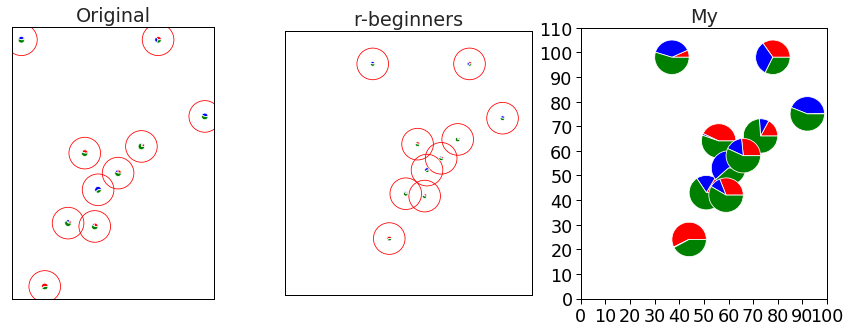

In [104]:
def plot_pie(x, ax, r=1): 
    # radius for pieplot size on a scatterplot
    ax.pie(x[['a','b','c']], center=(x['lat'],x['lon']), radius=r, colors=['r', 'b', 'g'])

sim_data = pd.DataFrame({'a':rand(),'b':rand(),'c':rand(), 'lat':rand(),'lon':rand()})


fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.patch.set_facecolor('white')

# original plot
ax = axs[0]
ax.scatter(x=sim_data['lat'], y=sim_data['lon'], s=1000, facecolor='none', edgecolors='r')
y_init = ax.get_ylim()
x_init = ax.get_xlim()
sim_data.apply(lambda x : plot_pie(x,ax), axis=1)
ax.set_ylim(y_init)
ax.set_xlim(x_init)
ax.set_title('Original')
ax.set_frame_on(True)

# r-beginner's solution
ax = axs[1]
ax.scatter(x=sim_data['lat'], y=sim_data['lon'], s=1000, facecolor='none', edgecolors='r')
y_init = ax.get_ylim()
x_init = ax.get_xlim()
sim_data.apply(lambda x : plot_pie(x,ax), axis=1)
ax.set_ylim([0, y_init[1]*1.1])
ax.set_xlim([0, x_init[1]*1.1])
ax.set_title('r-beginners')
ax.set_frame_on(True)

# my solution
ax = axs[2]
# do not use `s=` for size, it will not work properly when you are scattering pieplots
# because pieplots will be plotted above them
ax.scatter(x=sim_data['lat'], y=sim_data['lon'], s=0)
# git min/max values for the axes
y_init = ax.get_ylim()
x_init = ax.get_xlim()
sim_data.apply(lambda x : plot_pie(x, ax, r=7), axis=1)
# from zero to xlim/ylim with step 10
_ = ax.yaxis.set_ticks(range(0, round(y_init[1])+10, 10))
_ = ax.xaxis.set_ticks(range(0, round(x_init[1])+10, 10))
_ = ax.set_title('My')
ax.set_frame_on(True)

# Plot samples per clonotypes

In [117]:
# Style
# https://seaborn.pydata.org/generated/seaborn.axes_style.html
sns.set_style('ticks', {'axes.edgecolor': '0', #'axes.facecolor':'lightgrey',
                        'xtick.color': '0',
                        'ytick.color': '0'})#,
                        #'axes.grid': True,
                        #'axes.grid.axis' : 'x'})
sns.set_context("paper",font_scale=2)

In [118]:
def modify_legend(h,l):
    flag = False
    labels = []
    handles = []
    for e, le in enumerate(l):
        if flag:
            #if (int(le) % 10 == 0) | (le == '1'):
            labels.append(le)
            handles.append(h[e])
        if le == 'gems_per_specificity':
            flag = True

    idxs = np.linspace(0,len(labels)-1,5)
    l = []
    h = []
    for i in idxs:
        l.append(labels[int(i)])
        h.append(handles[int(i)])
    return h,l #handles, labels

In [119]:
df = calc_binding_concordance(df[idx & idx_df['specificity multiplets']].copy(), 'ct')

In [120]:
# Sort
df.ct = df.ct.astype(int).astype(str)
df.sort_values(by=['epitope_rank','gems_per_specificity','binding_concordance'], #,'ct'
                   ascending=[True, False, False], inplace=True) #, True

# devide GEMs by max concordance and outliers
dct = df.groupby('ct').binding_concordance.max()
df['max_conc'] = df.ct.map(dct)
max_conc = df.binding_concordance == df.max_conc

In [121]:
max_gems = df.gems_per_specificity.max() if df.gems_per_specificity.max() < 1000 else 1000
max_gems

243

In [122]:
pep_height = int(df.peptide_HLA.nunique()/2) # 6
pep_height

5

In [123]:
hsh_height = int(df.sample_id.nunique()/2)
hsh_height

5

In [124]:
fig_height = pep_height + hsh_height
fig_height

10

In [125]:
lw = 0.1 if len(plt_df) < 10000 else 0
lw

0.1

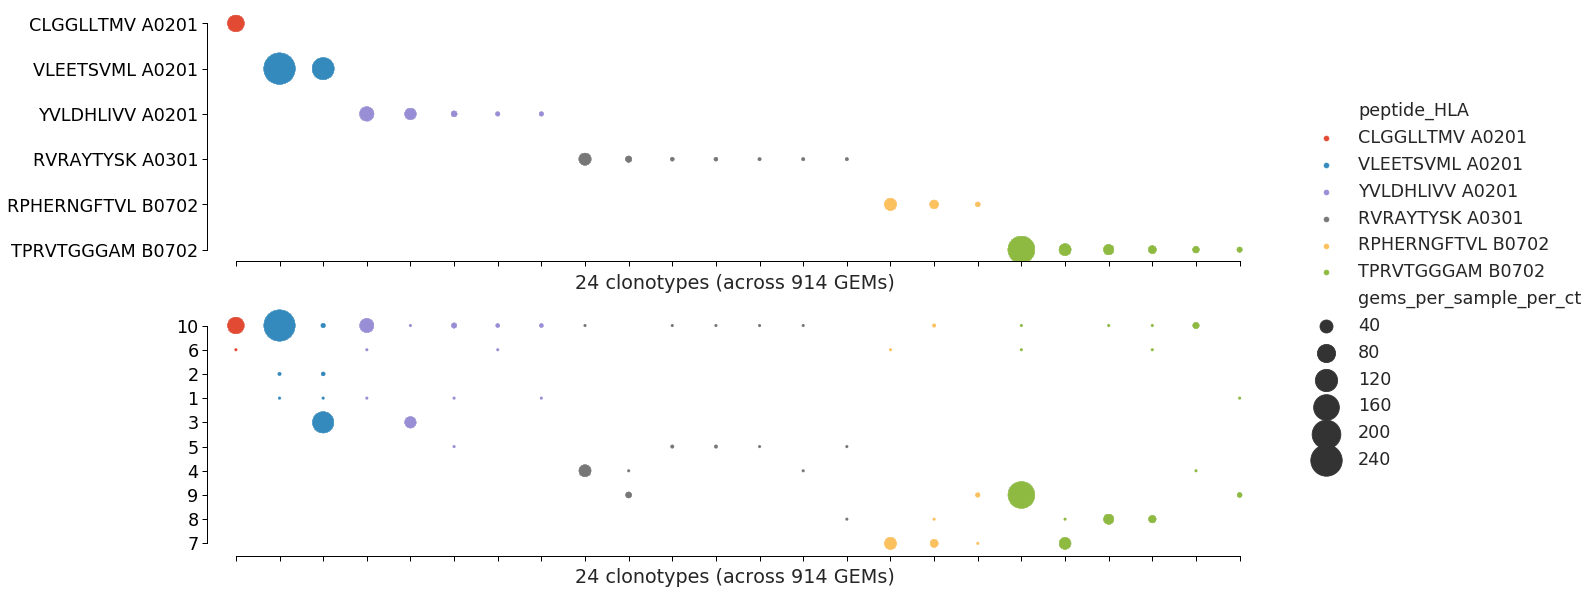

In [126]:
fig = plt.figure(figsize=(20,fig_height))
#fig.suptitle()

gs = gridspec.GridSpec(2, 1, height_ratios=[pep_height, hsh_height], hspace=0.3*6/fig_height) #6, left=0.05
ax1 = fig.add_subplot(gs[0]) #ax1 = plt.subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1], sharex=ax1) #ax2 = plt.subplot(gs[0,1])

#################################################
#                  Big scatter                  #
#################################################
#def plot_specificity(title, df, max_gems, save=True):
sub_df = df[max_conc].copy() # & (df.ct.isin(shared_cts))

shared_cts = sub_df.groupby('ct').sample_id.nunique()
shared_cts = shared_cts[shared_cts > 1].index

sub_df = sub_df[sub_df.ct.isin(shared_cts)].copy() # not grid!

sns.scatterplot(data=sub_df, x='ct', y='peptide_HLA',
                size='gems_per_specificity', sizes=(10,1000), size_norm=(1,max_gems),
                #hue='binding_concordance', palette='viridis_r', hue_norm=(0,1),
                hue='peptide_HLA',
                legend=False, linewidth=lw, ax=ax1) #legend='full'
#sns.scatterplot(data=df[~idx], x='ct', y='peptide_HLA',
#                size='gems_per_specificity', sizes=(10,1000), size_norm=(1,max_gems),
#                #hue='binding_concordance', palette='viridis_r', hue_norm=(0,1),
#                hue='peptide_HLA',
#                legend=False, linewidth=0, ax=ax1)

# sm = plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0,vmax=1), cmap='viridis_r') # hack for cbar
# sm.set_array([]) # hack for cbar
# fig.colorbar(sm, ax=ax1, orientation='horizontal', label='Binding Concordance', fraction=0.06*6/fig_height, pad=0.15*6/fig_height) #https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.colorbar.html

# h,l = ax.get_legend_handles_labels()
# h,l = modify_legend(h,l)
# ax.legend(h, l, bbox_to_anchor=(0.5, -0.5*6/fig_height), loc=9, frameon=False, title='GEMs', ncol=len(l))

ax1.set_xlabel('%d clonotypes (across %d GEMs)' %(sub_df.ct.nunique(), sub_df.gem.nunique()))
ax1.set_ylabel('')

sns.despine(bottom=False, trim=True, offset={'left':-30}, ax=ax1)
ax1.set_xticks([])
ax1.set_xticklabels([])

#################################################
#                 Small scatter                 #
#################################################
#sub_df['sample_id_old'] = sub_df.sample_id
#sub_df.sample_id = np.where((sub_df.hash_id != 'Doublet') &
#                            (sub_df.hash_id != 'Negative'), sub_df.hash_id, sub_df.sample_id)
dct = sub_df.groupby(['sample_id','ct']).size()
sub_df['gems_per_sample_per_ct'] = sub_df.set_index(['sample_id','ct']).index.map(dct)
dct = sub_df.groupby('ct').gem.size() #.gems_per_sample_per_ct.sum()
sub_df['gems_per_ct'] = sub_df.ct.map(dct)
sub_df['sample_concordance'] = sub_df.gems_per_sample_per_ct / sub_df.gems_per_ct
sub_df.sample_id = sub_df.sample_id.astype(int).astype(str)
sub_df.gems_per_sample_per_ct = np.where(sub_df.ct.isin(shared_cts), sub_df.gems_per_sample_per_ct, np.nan) # Hack
sns.scatterplot(data=sub_df, x='ct',y='sample_id',size='gems_per_sample_per_ct', 
                #hue='sample_concordance', palette='viridis_r',
                hue='peptide_HLA',
                sizes=(10,1000), size_norm=(1,max_gems),
                legend='brief', linewidth=lw, ax=ax2)

plt.legend(bbox_to_anchor=(0.9, 0.5), loc=6, frameon=False, bbox_transform=fig.transFigure)

ax2.set_xlabel('%d clonotypes (across %d GEMs)' %(sub_df[sub_df.ct.isin(shared_cts)].ct.nunique(), sub_df[sub_df.ct.isin(shared_cts)].gem.nunique()))
ax2.set_ylabel('')
sns.despine(bottom=False, trim=True, offset={'left':-30}, ax=ax2)
#ax2.set_xticks([])
ax2.set_xticklabels([])
ax2.set_ylim(sub_df.sample_id.nunique()-0.5, -0.8) # This is so weird!?!

#ax1.xaxis.grid(True)
#ax2.xaxis.grid(True)

plt.savefig('../../experiments/exp13/run3/plt/specificity_matrix/peptide_per_clonotype_by_gem_size/indv/thr_hla_by_sample.impute.png', bbox_inches='tight', dpi=300)
plt.show()

In [130]:
sub_df.loc[sub_df.ct.isin(shared_cts) & (sub_df.gems_per_sample_per_ct < 10), #
           ['ct','hto_classification','hto_max_id','hash_id','sample_id_lst','umi_count_lst_cd8','HLA_lst_cd8','peptide_HLA','umi_count_lst_mhc',
            'umi_count_lst_TRA','umi_count_lst_TRB']].sort_values(by='ct').tail(60)

,ct,hto_classification,hto_max_id,hash_id,sample_id_lst,umi_count_lst_cd8,HLA_lst_cd8,peptide_HLA,umi_count_lst_mhc,umi_count_lst_TRA,umi_count_lst_TRB
3542,175,9,9,9,"[3, 4, 2, 1, 7, 6, 8, 10, 9]","[2.0, 3.0, 6.0, 8.0, 8.0, 9.0, 11.0, 25.0, 142...","[['A0201'], ['A0301', 'B0702'], ['A0201'], ['A...",RPHERNGFTVL B0702,"[2.0, 5.0]",[4],[4]
2964,18,10_8,8,Doublet,"[3, 5, 4, 9, 7, 1, 6, 2, 8, 10]","[3.0, 4.0, 5.0, 9.0, 12.0, 13.0, 13.0, 22.0, 8...","[['A0201'], ['A0301', 'B0702'], ['A0301', 'B07...",TPRVTGGGAM B0702,[31.0],[3],[14]
1518,2,5_9,9,Doublet,"[3, 4, 8, 2, 1, 7, 6, 5, 9, 10]","[1.0, 2.0, 4.0, 5.0, 7.0, 7.0, 14.0, 157.0, 10...","[['A0201'], ['A0301', 'B0702'], ['A0301', 'B07...",TPRVTGGGAM B0702,"[1.0, 3.0, 13.0]",[1],[8]
2399,2,6_9,6,Doublet,"[3, 5, 8, 4, 2, 7, 1, 10, 9, 6]","[4.0, 4.0, 4.0, 8.0, 9.0, 9.0, 23.0, 33.0, 143...","[['A0201'], ['A0301', 'B0702'], ['A0301', 'B07...",TPRVTGGGAM B0702,"[1.0, 1.0, 5.0, 35.0]",[3],[5]
388,32,6_8,6,Doublet,"[3, 5, 2, 4, 7, 9, 10, 8, 1, 6]","[1.0, 2.0, 3.0, 3.0, 8.0, 9.0, 9.0, 292.0, 364...","[['A0201'], ['A0301', 'B0702'], ['A0201'], ['A...",TPRVTGGGAM B0702,[5.0],[3],[8]
1936,32,10_8,8,Doublet,"[4, 3, 1, 2, 7, 6, 9, 8, 10]","[1.0, 2.0, 3.0, 3.0, 4.0, 6.0, 7.0, 295.0, 402.0]","[['A0301', 'B0702'], ['A0201'], ['A0201', 'B07...",TPRVTGGGAM B0702,"[1.0, 8.0]",[4],[8]
1811,33,10_4,10,Doublet,"[3, 5, 2, 8, 1, 9, 6, 4, 7, 10]","[1.0, 4.0, 7.0, 9.0, 17.0, 21.0, 22.0, 33.0, 3...","[['A0201'], ['A0301', 'B0702'], ['A0201'], ['A...",RPHERNGFTVL B0702,[5.0],[1],[7]
2755,33,2_8,8,Doublet,"[4, 3, 6, 1, 7, 10, 2, 8]","[1.0, 3.0, 5.0, 9.0, 11.0, 20.0, 100.0, 836.0]","[['A0301', 'B0702'], ['A0201'], ['A0201', 'B07...",RPHERNGFTVL B0702,"[2.0, 3.0]",[2],[11]
2030,33,10,10,10,"[5, 4, 8, 7, 9, 1, 6, 2, 10]","[1.0, 2.0, 2.0, 3.0, 3.0, 7.0, 8.0, 20.0, 939.0]","[['A0301', 'B0702'], ['A0301', 'B0702'], ['A03...",RPHERNGFTVL B0702,"[1.0, 4.0]",[2],[16]
139,374,4,4,4,"[3, 5, 7, 8, 2, 1, 10, 4]","[1.0, 1.0, 2.0, 3.0, 8.0, 10.0, 16.0, 1478.0]","[['A0201'], ['A0301', 'B0702'], ['B0702'], ['A...",RVRAYTYSK A0301,[9.0],[6],[12]


In [129]:
sub_df.dropna(subset=['gems_per_sample_per_ct']).groupby(['ct','sample_id']).gems_per_sample_per_ct.max().tail(60)

ct   sample_id
1    1              1.0
     10           240.0
     2              2.0
11   1              1.0
     10            48.0
     6              1.0
113  1              1.0
     10             3.0
118  10             1.0
     5              2.0
12   6              1.0
     7             35.0
13   10             1.0
     3             31.0
130  5              1.0
     8              1.0
134  10             1.0
     5              1.0
14   10             1.0
     4             35.0
15   7             34.0
     8              1.0
175  7              1.0
     9              4.0
18   10             1.0
     8             25.0
2    10             1.0
     6              1.0
     9            176.0
32   10             1.0
     6              1.0
     8             13.0
33   10             2.0
     7             15.0
     8              1.0
374  10             1.0
     4              1.0
4    1              1.0
     10             4.0
     2              3.0
     3            111.0
4

In [185]:
sub_df[['sample_id','ct','peptide_HLA','gems_per_sample_per_ct','gems_per_ct','gems_per_clonotype','sample_concordance']].head(60)

,sample_id,ct,peptide_HLA,gems_per_sample_per_ct,gems_per_ct,gems_per_clonotype,sample_concordance
521,10,848,GILGFVFTL A0201,1,1,1,1.000000
795,2,604,GILGFVFTL A0201,1,1,1,1.000000
1024,6,573,GLCTLVAML A0201,1,1,1,1.000000
1916,6,478,GLCTLVAML A0201,1,1,1,1.000000
2332,1,278,GLCTLVAML A0201,1,1,1,1.000000
1478,10,225,GLCTLVAML A0201,2,2,2,1.000000
722,10,472,NLVPMVATV A0201,1,1,1,1.000000
1870,10,1984,NLVPMVATV A0201,1,1,1,1.000000
3063,2,811,NLVPMVATV A0201,1,1,1,1.000000
3131,3,1985,NLVPMVATV A0201,1,1,1,1.000000


In [164]:
sub_df.loc[(sub_df.peptide_HLA =='YVLDHLIVV A0201') & (sub_df.ct =='96'), ['ct','sample_id']]

,ct,sample_id
448,96,10
1397,96,10
3123,96,6
3611,96,10


In [172]:
dct = sub_df.groupby('ct').gems_per_sample_per_ct.sum()
sub_df['gems_per_ct'] = sub_df.ct.map(dct)

In [176]:
sub_df['sample_concordance'] = sub_df.gems_per_sample_per_ct / sub_df.gems_per_ct

In [167]:
df.columns.to_list()

['gem',
 'clonotype',
 'num_clonotype',
 'ct',
 'genes_TRA',
 'genes_TRB',
 'genes_lst_TRA',
 'genes_lst_TRB',
 'length_TRA',
 'cdr1_TRA',
 'cdr2_TRA',
 'cdr3_TRA',
 'umi_count_TRA',
 'umi_count_lst_TRA',
 'delta_umi_TRA',
 'cdr3_lst_TRA',
 'chain_count_TRA',
 'single_TRA',
 'length_TRB',
 'cdr1_TRB',
 'cdr2_TRB',
 'cdr3_TRB',
 'umi_count_TRB',
 'umi_count_lst_TRB',
 'delta_umi_TRB',
 'cdr3_lst_TRB',
 'chain_count_TRB',
 'single_TRB',
 'single_chain_only',
 'umi_count_tcr',
 'cdr3_comb',
 'v_gene_TRA',
 'j_gene_TRA',
 'v_gene_TRB',
 'j_gene_TRB',
 'tcr_category',
 'no_filtration',
 'exclude_single-chain_TCRs',
 'exclude_ambiguous_and_single-chain_TCRs',
 'exclude_ambiguous_TCRs',
 'label',
 'umi_count_mhc',
 'umi_count_lst_mhc',
 'delta_umi_mhc',
 'single_barcode_mhc',
 'multiplets_mhc',
 'umi_count_cd8',
 'umi_count_lst_cd8',
 'delta_umi_cd8',
 'single_barcode_cd8',
 'multiplets_cd8',
 'detected_response',
 'peptide_assayed',
 'sample_id',
 'sample_id_lst',
 'HLA_pool_cd8',
 'HLA_lst_

In [150]:
dct = sub_df.groupby(['sample_id','ct']).size()
sub_df['gems_per_sample_per_ct'] = sub_df.set_index(['sample_id','ct']).index.map(dct)

/home/people/herpov/.conda/envs/snakemake/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [107]:
dct = df.groupby('ct').binding_concordance.max()
df['max_conc'] = df.ct.map(dct)

In [109]:
sub_df = df[df.max_conc == df.binding_concordance]

In [ ]:
sub_df.groupby('sample_id')

In [102]:
df.binding_concordance

0       1.000000
1       1.000000
2       0.966887
3       1.000000
4       1.000000
          ...   
4114    0.975904
4116    1.000000
4117    0.941176
4121    0.013245
4122    1.000000
Name: binding_concordance, Length: 2827, dtype: float64

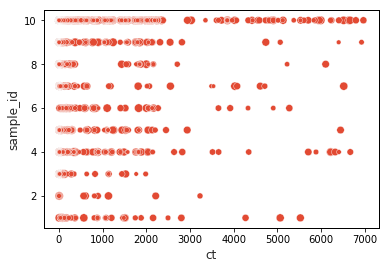

In [112]:
sns.scatterplot(data=sub_df, x='ct',y='sample_id',size='gem', legend=False)

# Plotting distribution of specificities per sample

In [37]:
plt_df = df[idx].groupby(['sample_id','ct']).gem.size().to_frame().reset_index()
plt_df

,sample_id,ct,gem
0,1.0,1.0,1
1,1.0,4.0,1
2,1.0,11.0,1
3,1.0,35.0,3
4,1.0,50.0,1
...,...,...,...
1067,10.0,6519.0,1
1068,10.0,6641.0,1
1069,10.0,6670.0,1
1070,10.0,6800.0,1


1.0 47


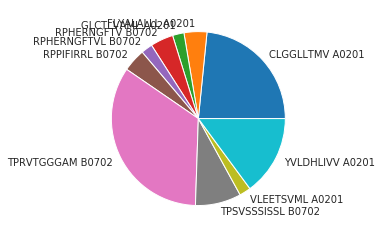

2.0 11


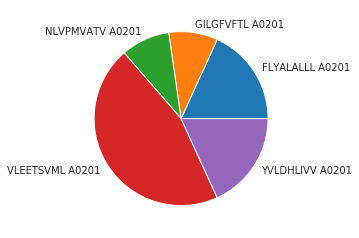

3.0 181


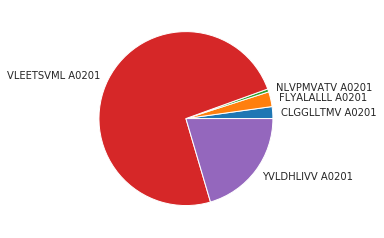

4.0 183


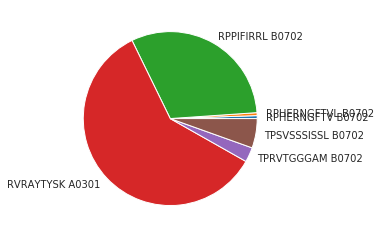

5.0 138


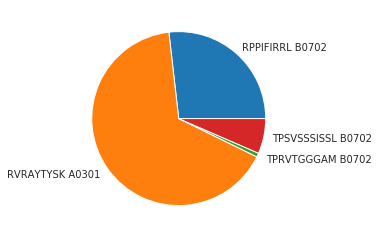

6.0 68


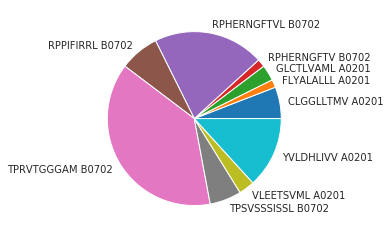

7.0 256


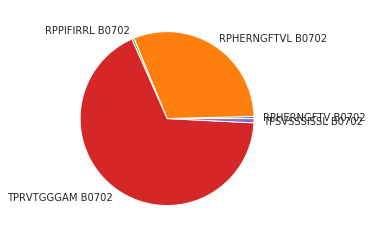

8.0 264


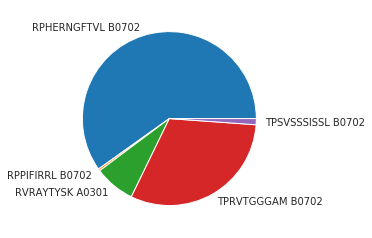

9.0 270


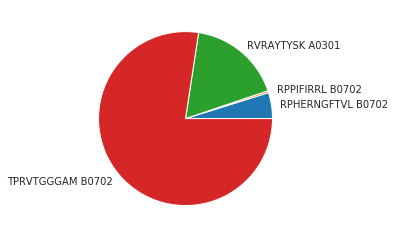

10.0 1409


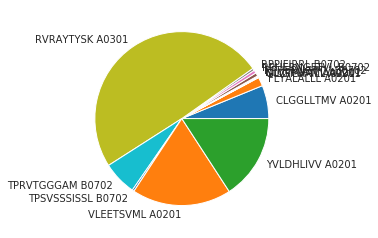

In [36]:
for s, grp in df[idx].groupby('sample_id'):
    print(s, len(grp))
    g = grp.groupby('peptide_HLA').ct.size()
    plt.pie(g.values, labels=g.index)
    plt.show()